# Bayesian prediction: autoregressive process

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import t
import pandas as pd 
from utils import simAR1, cycle, embed, posterior_betas, Predictive

Data generating process:

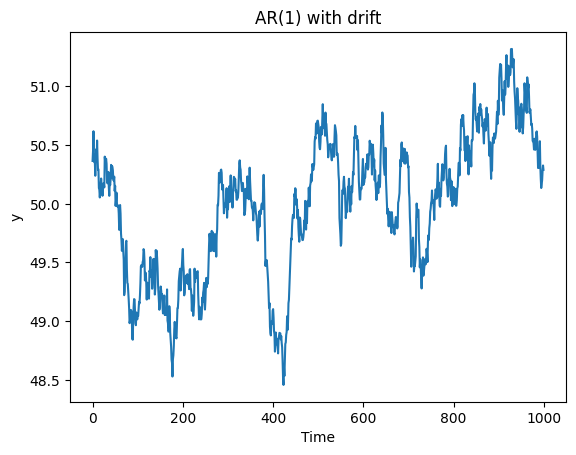

In [19]:
# Parameters for simAR1 function
N = 1000      # number of observations
phi = 0.98   # AR(1) parameter
sigma = 0.1  # Standard deviation
const = 1    # Constant term
burn = 1000  # Burn-in period

# Simulate the AR(1) process
y = simAR1(N, phi, sigma, const, burn)
#y = omega*cycle(N, nof_cycles = 2) + simAR1(N, phi = phi_true, sigma = sigma_true, const = 0.5)
#y = omega*cycle(N, nof_cycles = 2)

# Plot trajectories:
#---------------------
plt.figure()
pd.Series(y).plot()
plt.title("AR(1) with drift")
plt.xlabel("Time")
plt.ylabel("y")
#plt.savefig("trajectory_ar1.png", dpi=300) 
plt.show()

Create 'lagged feature' matrix:

In [20]:
# Create lagged versions of the data
X_embed = embed(pd.DataFrame(y, columns=['y']), lags = 1, dropnan=True)

X_embed['const'] = 1
y = X_embed['y_lag0']
X = X_embed.drop(columns=['y_lag0'])

# Use a portion of X (like the last row) as X_new for prediction
y_new = y.values[-1]
X_new = X.iloc[-1:].values
X = X.values[:-1]
y = y.values[:-1]

Compute the posterior parameters $\beta$:

In [21]:
# Define the posterior parameters
beta_0 = np.zeros(X.shape[1])     # Prior mean (vector of zeros)
M0 = np.eye(X.shape[1])           # Prior covariance matrix (identity matrix)
s0 = 1                            # Prior scale parameter
nu0 = 5                           # Prior degrees of freedom

beta_star, beta_ols, varcov_beta, M_star, s_star, nu_star = posterior_betas(X, y, beta_0, M0, s0, nu0)
beta_star, varcov_beta

(array([0.99789469, 0.10510049]),
 array([[ 8.75826055e-01, -4.37388033e+01],
        [-4.37388033e+01,  2.18681270e+03]]))

Compute the posterior predictive distribution:

In [22]:
pred = Predictive(verbose=True)

predictive_mean, predictive_varcov = pred.posterior_predictive(X, X_new, y, beta_0=beta_0, M0=M0, s0=s0, nu0=nu0)
print(predictive_mean, predictive_varcov)

print("True value of y:", y_new)

--- Predictive distribution of y_new given X_new and y ---
[50.32543881] [[2494.48972538]]
True value of y: 50.289096243794575


In [23]:
draws = pred.draw(size=1000)

Plot posterior predictive distribution of $y_{T+1}|y_{1:T}$

True value of y: 50.29
Predictive mean: 50.33
Predictive interval: [-36.24, 129.36]


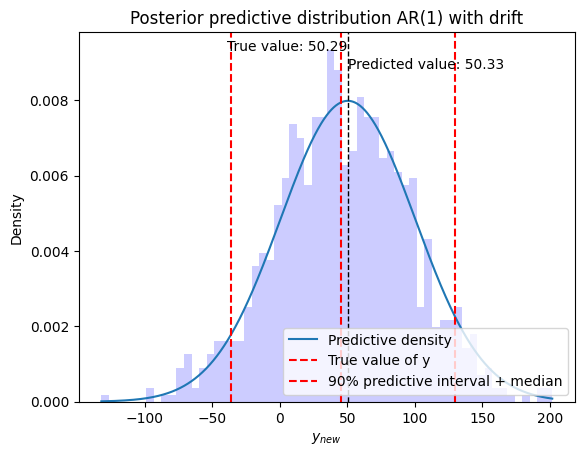

In [24]:
# Assuming 'draws', 'y_new', 'predictive_mean', and 'mvt' are defined earlier in your code
x_axis = np.linspace(start=min(draws), stop=max(draws), num=1000)
alpha = 0.1
quantiles = np.quantile(draws, q=[alpha/2, 0.5, 1-alpha/2], axis=0)

print(f"True value of y: {y_new:.2f}")
print(f"Predictive mean: {predictive_mean[0]:.2f}")
print(f"Predictive interval: [{quantiles[0]:.2f}, {quantiles[2]:.2f}]")

plt.hist(draws, bins=60, density=True, alpha=0.2, color='blue')  # density estimate
plt.plot(x_axis, pred.mvt.pdf(x=x_axis))                              # theoretical predictive density

# Add vertical lines for each quantile
for q in quantiles:
    plt.axvline(x=q, color='r', linestyle='--')

# Add true value of y
plt.axvline(x=y_new, color='black', linestyle='dashed', linewidth=1)

# Add text annotations for predicted value and true value
plt.text(y_new, plt.ylim()[1]*0.95, f'True value: {y_new:.2f}', horizontalalignment='right')
plt.text(predictive_mean[0], plt.ylim()[1]*0.9, f'Predicted value: {predictive_mean[0]:.2f}', horizontalalignment='left')

plt.legend(['Predictive density', 'True value of y', f"{(1-alpha)*100:.0f}% predictive interval + median"], loc='lower right')
plt.title('Posterior predictive distribution AR(1) with drift')
plt.xlabel(r'$y_{new}$')
plt.ylabel("Density")
#plt.savefig("marg_posterior_predictive_plot_AR1.png", dpi=300)
plt.show()

In [25]:
from utils import sample_cond_post_betas_sigma2, sample_marg_post_sigma2

samples_betas = sample_cond_post_betas_sigma2(X, y, sigma2=1.0, size=1000)

samples_sigma2 = sample_marg_post_sigma2(X, y, size=10000)

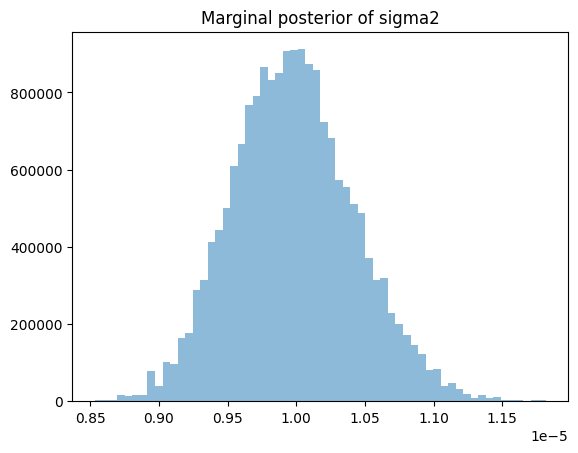

In [31]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1)
ax.hist(samples_sigma2, density=True, bins='auto', histtype='stepfilled', alpha=0.5)
plt.title("Marginal posterior of sigma2")
plt.show();

### Posterior of the log predictive density: $\log p(y| \theta) = \log{\prod_{t=1}^{T} p(y_{t}| \beta, \sigma^2)}$

Note: Uncertainty comes through the uncertainty of $\theta$

Sample from joint posterior of $\beta$ and $\sigma^2$:

In [27]:
from utils import samples_joint_beta_sigma2

samples_joint = samples_joint_beta_sigma2(X, y, size=1000)
samples_joint.shape

(1000, 3)

In [28]:
from tqdm.auto import tqdm
from scipy.stats import norm

joint_log_pdf = []
for j in tqdm(range(samples_joint.shape[0])):
    betas_j = samples_joint[j,:-1]              # posterior sample of betas
    sigma2_j = samples_joint[j,-1]              # posterior sample of sigma2
    # Compute the log of the joint data density given the posterior sample of betas and sigma2
    log_pdf = np.array([norm.logpdf(y[i], loc=X[i,:].dot(betas_j), scale=np.sqrt(sigma2_j)) for i in range(X.shape[0])])
    joint_log_pdf.append(log_pdf.sum())

  0%|          | 0/1000 [00:00<?, ?it/s]

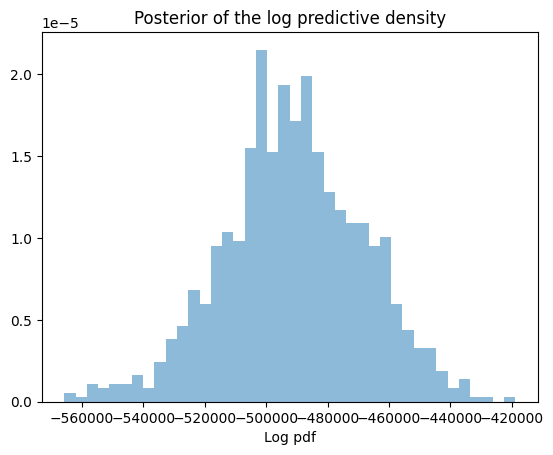

In [29]:
# Plot the posterior of the joint log pdf
#-----------------------------------------
fig, ax = plt.subplots(1, 1)
ax.hist(joint_log_pdf, density=True, bins=40, histtype='stepfilled', alpha=0.5)
plt.title("Posterior of the log predictive density")
plt.xlabel("Log pdf")
plt.show();

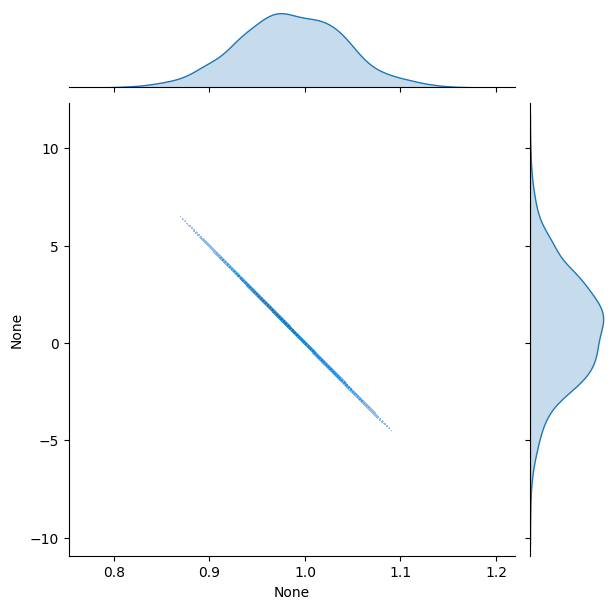

In [30]:
import seaborn as sns

sns.jointplot(x=samples_betas[:,0], y=samples_betas[:,1], kind='kde', fill=True);